In [1]:
import numpy as np #We will make extensive use of Numpy arrays 
from numpy.fft import fft2, ifft2 #for convolution work

from photutils import CircularAperture,aperture_photometry
import scipy.signal as signal

import matplotlib  #ploting
matplotlib.use("Agg")  #some hack to stop the bouncing python icon when plotting of os/x
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams.update({'font.size': 24}) #adjust font

In [17]:
def calc_noise(flux,exptime,gain=1.1,readnoise=8.0,photap=1.0,darknoise=1.25):
    
    #flux : total flux inside photometric aperture (e-)
    #exptime : gives the exposure time (s)
    #gain : (e- ADU^-1)
    #readnoise : (e-)
    #photap : number of pixels in photometric aperture (pixels)
    #darknoise : (e- s^-1)
    
    shotnoise=np.sqrt(flux) #Shot noise
    detectnoise=np.sqrt(np.pi*photap*photap)*(readnoise+darknoise*exptime)
    predictnoise=np.sqrt(shotnoise*shotnoise+detectnoise*detectnoise)
    
    return predictnoise

In [3]:
def fstarcalc(gmag,stype=0):
    
    #g-magnitude (GAIA)
    #stype : 0 = G2V star, 1 = K5V star, 2 = M5V star
    #returns the number of e- s-1 that reaches the detector (after all optical losses)
    
    if stype==0:  #G2V
        fzero=1.601E+05
    elif stype==1: #K5V
        fzero=2.406E+05
    elif stype==2: #M5V
        fzero=3.335E+05
    else:
        fzero=1.601E+05 #default to Sun-like star
    
    fstar=np.power(10,(7.5-gmag)/2.5)*fzero
    
    return fstar

In [5]:
def genKernel(nKs,noversample,sx,sy,sxy):
    
    Kernel=np.zeros((nKs,nKs))
    
    xc=int(nKs/2+0.5) #center of PSF
    yc=int(nKs/2+0.5)

    
    for i in range(nKs):
        xd=(i-xc)/noversample #distance from centre of PSF
        for j in range(nKs):
            yd=(j-yc)/noversample
            expt1=-((xd/sx)**2.0)
            expt2=-((yd/sy)**2.0)
            expt3=2.0*sxy*(xd*yd)/(sx*sy)
            Kernel[i,j]=np.exp(expt1+expt2+expt3)
    Kernel=Kernel/np.sum(Kernel) #normalize
    return Kernel;

In [6]:
def fft_convolve2d(x,y):
    """ 2D convolution, using FFT"""
    fr = fft2(x)
    fr2 = fft2(np.flipud(np.fliplr(y)))
    m,n = fr.shape
    cc = np.real(ifft2(fr*fr2))
    cc = np.roll(cc, int(-m/2+1),axis=0)
    cc = np.roll(cc, int(-n/2+1),axis=1)
    return cc

In [7]:
def binimage(pixels_c,xmax,ymax,noversample):

    xsub=int(xmax/noversample)
    ysub=int(ymax/noversample)
    pixels_n=np.zeros((xsub,ysub))
    for i in range(0,xmax,noversample):
        for j in range(0,ymax,noversample):
            #print(i,i+noversample,j,j+noversample)
            ni=int(i/noversample)
            nj=int(j/noversample)
            #print(ni,nj)
            pixels_n[ni,nj]=np.sum(pixels_c[i:i+noversample,j:j+noversample])
            #print(pixels_n[ni,nj])
            #input()
    return pixels_n;

In [4]:
#Simulation parameters

exptime=2.0        #exposure time in seconds
gmag=8.0           #g-magnitude of star (GAIA)
stype=0            #stellar type.  0=G2V,1=K5V,2=M5V

gain=1.1           #gain (e-/ADU)
readnoise=8.0      #read noise (e-)
darknoise=1.25     #dark current (e- s-1 pix-1)

photap=4.0         #photometric aperture (pixels)
sx=3.0           #PSF Gaussian width (pixels)
sy=3.0           #PSF Gaussian width (pixels)
sxy=0.0          #xy width (non-circular)
subraster=128     #size of subraster for simulation (pixels)
noversample=8     #oversampling parameter to reduce digital artifacts

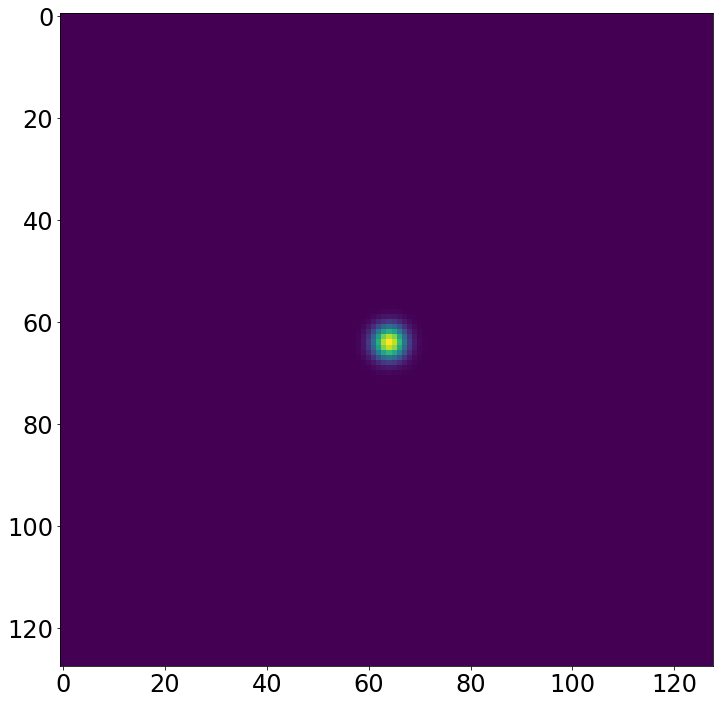

Exposure Time (s):            2.0
Star g-mag:                   8.0
Flux reaching detector (ADU): 183665.95
Max Pixel Value (ADU):        6373.48
Flux inside aperture:         146955.80
Photometric noise (ADU):      414.18
Estimated SNR:                443.44


In [24]:
fstar=fstarcalc(gmag,stype=stype)  #get flux from detector (e- s^-1)
flux=fstar*exptime

#Create Array for Simulation
xmax=subraster*noversample;ymax=subraster*noversample
pixels=np.zeros((xmax,ymax)) #will hold unconvolved pixel map
nKs=xmax #natural size of Kernels times oversampling
xcoo=xmax/2+noversample*np.random.rand() #centroid for object. Near center with random 1 natural pixel jitter
ycoo=ymax/2+noversample*np.random.rand() #centroid for object. Near center with random 1 natural pixel jitter

#Add flux to oversampled grid
pixels[int(xcoo),int(xcoo)]=np.copy(flux)

#create convolution Kernel
Kernel=genKernel(nKs,noversample,sx,sy,sxy)

#Convolve oversampled image with PSF (Kernel)
pixels_c=fft_convolve2d(pixels,Kernel)

#bin down to native resolution
pixels_n=binimage(pixels_c,xmax,ymax,noversample)

#Extract Photometry with circular aperture
positions = [(xcoo/noversample, ycoo/noversample)]
aperture = CircularAperture(positions, r=photap)
phot_table = aperture_photometry(pixels_n, aperture)

#Estimate noise inside photometry aperture
noise=calc_noise(flux,exptime,gain=gain,readnoise=readnoise,photap=photap,darknoise=darknoise)

plt.figure(figsize=(12,12)) #adjust size of figure
plt.imshow(pixels_n)
plt.show()

#Print some stats
print('Exposure Time (s):           ',exptime)
print('Star g-mag:                  ',gmag)
print('Flux reaching detector (ADU):', "{:.2f}".format(flux/gain))
print('Max Pixel Value (ADU):       ',"{:.2f}".format(np.max(pixels_n/gain)))
print('Flux inside aperture:        ',"{:.2f}".format(np.float(phot_table['aperture_sum'][0])/gain))
print('Photometric noise (ADU):     ',"{:.2f}".format(noise/gain))
print('Estimated SNR:               ',"{:.2f}".format(flux/noise))